In [28]:
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

import os
import numpy 
from PIL import Image
import matplotlib.pyplot as plt

In [18]:
train_dir = '/kaggle/input/10-monkey-species/training/training/'
val_dir = '/kaggle/input/10-monkey-species/validation/validation/'

In [19]:
class MonkeyDataset(Dataset):
    
    def __init__(self,file_list,directory,transform = None):
        self.file_list = file_list
        self.directory = directory
        self.label = None
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.directory, self.file_list[idx]))
        img = self.transform(img)
        
        if 'n0' in self.file_list[0]:
            self.label = 0
        elif 'n1' in self.file_list[0]:
            self.label = 1
        elif 'n2' in self.file_list[0]:
            self.label = 2
        elif 'n3' in self.file_list[0]:
            self.label = 3
        elif 'n4' in self.file_list[0]:
            self.label = 4
        elif 'n5' in self.file_list[0]:
            self.label = 5
        elif 'n6' in self.file_list[0]:
            self.label = 6
        elif 'n7' in self.file_list[0]:
            self.label = 7
        elif 'n8' in self.file_list[0]:
            self.label = 8
        elif 'n9' in self.file_list[0]:
            self.label = 9
        
        img = img.numpy()
        return img.astype('float32'), self.label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

val_transform = data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [20]:
classes = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
trainset = None
for c in classes:
    file_dir = os.path.join(train_dir,c)
    file_list = os.listdir(file_dir)
    new = MonkeyDataset(file_list,file_dir,train_transform)
    
    if trainset == None:
        trainset = new
    else:
        trainset = ConcatDataset([trainset,new])

trainloader = DataLoader(trainset, batch_size = 32,num_workers=4,shuffle=True)

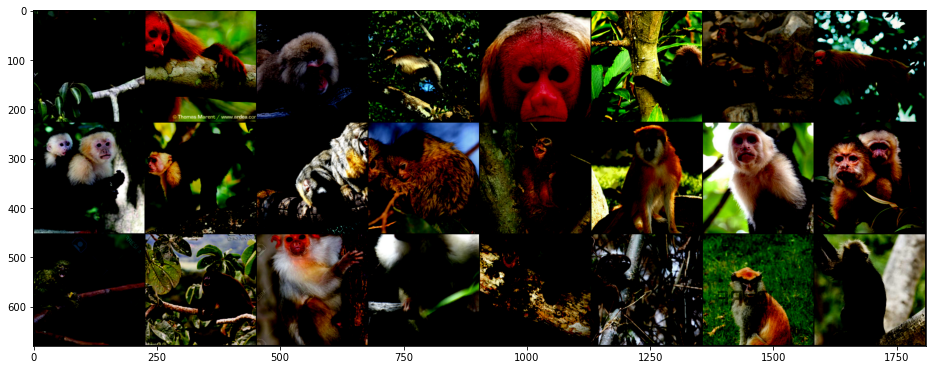

In [21]:
samples, labels = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [22]:
valset = None
for c in classes:
    file_dir = os.path.join(val_dir,c)
    file_list = os.listdir(file_dir)
    
    new = MonkeyDataset(file_list,file_dir,val_transform)
    
    if valset == None:
        valset = new
    else:
        valset = ConcatDataset([valset,new])
    print("")

valloader = DataLoader(valset, batch_size = 32,num_workers=4,shuffle=True)

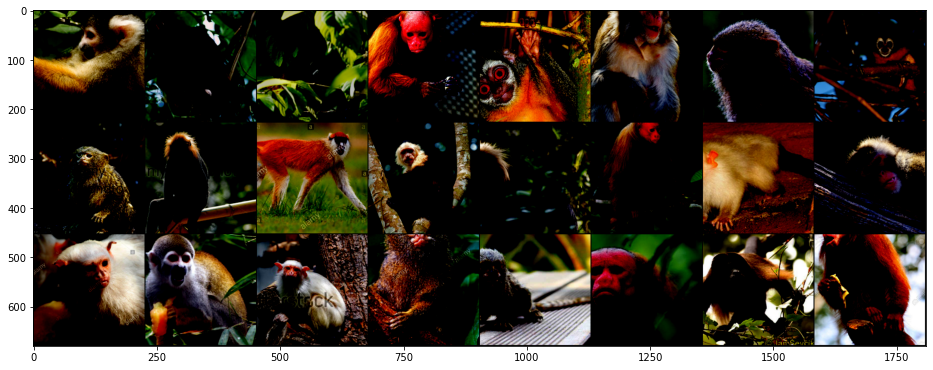

In [23]:
samples, labels = iter(valloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [24]:
device = 'cuda'

In [37]:
vgg16_backbone = models.vgg16(pretrained=True)

for param in vgg16_backbone.parameters():
      param.requires_grad = False

class VGG16(nn.Module):
  def __init__(self):
    super(VGG16, self).__init__()
    self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

    self.drop1 = nn.Dropout(0.3)
    self.drop2 = nn.Dropout(0.2)

    self.fc1 = nn.Linear(512*7*7,1024)
    self.fc2 = nn.Linear(1024,512)
    self.fc3 = nn.Linear(512,256)
    self.fc4 = nn.Linear(256,128)
    self.fc5 = nn.Linear(128,64)
    self.fc6 = nn.Linear(64,10)

  def forward(self,x):
    
    x = self.features(x)

    x = x.view(x.shape[0],512*7*7)
    
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2(x))
    x = self.drop1(x)
    x = F.relu(self.fc3(x))
    x = self.drop1(x)
    x = F.relu(self.fc4(x))
    x = self.drop2(x)
    x = F.relu(self.fc5(x))
    x = self.drop2(x)
    x = self.fc6(x)

    return x       

vgg_model = VGG16()
vgg_model = vgg_model.to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.003,momentum=0.9)

In [39]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [41]:
for epoch in range(10):
  print("Epoch:",epoch+1)
  running_loss = 0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    output = vgg_model(inputs)
    output = output.to(device)
    loss = criterion(output, labels)
    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    
    if i % 6 == 5:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 6))
      running_loss = 0.0
  
  print("EPOCH OVER")
  train_acc = model_eval(trainloader,vgg_model)
  test_acc = model_eval(valloader,vgg_model)
  print("############################")
  print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
  print("############################")
  print("")

Epoch: 1
[1,     6] loss: 2.301
[1,    12] loss: 2.296
[1,    18] loss: 2.300
[1,    24] loss: 2.296
[1,    30] loss: 2.292
EPOCH OVER
############################
Training Accuracy: 17.48633879781421 Testing Accuracy 16.176470588235293
############################

Epoch: 2
[2,     6] loss: 2.293
[2,    12] loss: 2.279
[2,    18] loss: 2.270
[2,    24] loss: 2.265
[2,    30] loss: 2.221
EPOCH OVER
############################
Training Accuracy: 18.852459016393443 Testing Accuracy 15.808823529411764
############################

Epoch: 3
[3,     6] loss: 2.126
[3,    12] loss: 1.975
[3,    18] loss: 1.898
[3,    24] loss: 1.916
[3,    30] loss: 1.838
EPOCH OVER
############################
Training Accuracy: 40.16393442622951 Testing Accuracy 34.9264705882353
############################

Epoch: 4
[4,     6] loss: 1.432
[4,    12] loss: 1.498
[4,    18] loss: 1.298
[4,    24] loss: 1.068
[4,    30] loss: 1.220
EPOCH OVER
############################
Training Accuracy: 65.20947176684882